In [27]:
'''
Loads data, trains som.py
'''
import sys
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib
import json

def lookup(num):
    var_list = ['Bearing-In-Vib', 'Bearing-Out-Vib', 'Motor-In-Vib', 'Motor-Out-Vib']
    if num < 8: var = var_list[0]
    elif (num > 8) and (num < 16): var = var_list[1]
    elif (num > 16) and (num < 24): var = var_list[2]
    else: var = var_list[3]
        
    num = num % 8
    name_lookup = {'0': 'pk-to-pk', '1': 'rms', '2': 'kurtosis', '3': 'skew', '4': 'standard-deviation'}
    #name_lookup = {'0': 'entropy', '1': 'no-peaks', '2': 'highest-autocorr', '3': 'skew', '4': 'standard-deviation'}
    name_lookup = {k: v + '-' + var for (k, v) in name_lookup.items()}
    
    n=0
    for name in var_list:
        if name != var:
            name_lookup.update({str(n+5):'corr-' + var + '-' + name})
            n+=1
            
    return name_lookup[str(num)]

def get_training_data():
    train = np.loadtxt('../data/training-data-som.csv', delimiter = ',')
    df1 = np.loadtxt("../data/testing-data-som.csv", delimiter = ',')
    df2 = np.loadtxt("../data/testingtwo-data-som.csv", delimiter = ',')
    df3 = np.loadtxt("../data/testingthree-data-som.csv", delimiter = ',')
    df_failure = np.loadtxt("../data/failure-data-som.csv", delimiter = ',')
    return train, df1, df2, df3, df_failure

def get_training_data_north():
    train = np.loadtxt('../data/training-north-data-som.csv', delimiter = ',')
    df1 = np.loadtxt("../data/testing-north-data-som.csv", delimiter = ',')
    df2 = np.loadtxt("../data/testingtwo-north-data-som.csv", delimiter = ',')
    df3 = np.loadtxt("../data/testingthree-north-data-som.csv", delimiter = ',')
    df_failure = np.loadtxt("../data/failure-north-data-som.csv", delimiter = ',')
    return train, df1, df2, df3, df_failure

def select_vars(train, df1, df2, df3, df_failure, sel, just_corr):
    # standardize selected vars except for correlations
    if not just_corr:
        sel_not_corr = [n for n in sel if "corr" not in lookup(n)]
        sel_corr = [n for n in sel if "corr" in lookup(n)]
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        strain = sc.fit_transform(train[:,sel_not_corr])
        sdf1 = sc.transform(df1[:,sel_not_corr])
        sdf2 = sc.transform(df2[:,sel_not_corr])
        sdf3 = sc.transform(df3[:,sel_not_corr])
        sdf_failure = sc.transform(df_failure[:,sel_not_corr])

        train = np.concatenate((strain, train[:,sel]), axis=1)
        df1 = np.concatenate((sdf1, df1[:,sel]), axis=1)
        df2 = np.concatenate((sdf2, df2[:,sel]), axis=1)
        df3 = np.concatenate((sdf3, df3[:,sel]), axis=1)
        df_failure = np.concatenate((sdf_failure, df_failure[:,sel]), axis=1)

        return train, df1, df2, df3, df_failure
        
    if just_corr:
        train = train[:,sel]
        df1 = df1[:,sel]    
        df2 = df2[:,sel]    
        df3 = df3[:,sel]    
        df_failure = df_failure[:,sel] 
    
    return train, df1, df2, df3, df_failure

def create_label(a, val):
    s = a.shape[0]
    if val == 0: b = np.zeros(s)
    else: b = np.ones(s)
    return b


In [28]:

def gen_plots(train, df1, df2, df3, df_failure):
    dfs = [train, df1, df2, df3, df_failure]
    dataset_labels = ['2-7', '1-1', '1-16', '1-7', '1-14 (failure)']
          
    for col in range(0, train.shape[1]):
        mean = [np.mean(d[:,col]) for d in dfs]
        error = [np.std(d[:,col]) for d in dfs]
        fig, ax = plt.subplots(figsize=(15,10))
        ax.bar(np.arange(len(mean)), mean, yerr=error, align='center', alpha=0.5, 
                                    ecolor='black', capsize=25)
        ax.set_ylabel(col)
        ax.set_xticks(np.arange(len(mean)))
        ax.set_xticklabels(dataset_labels)
        ax.set_title('Range of Variable ' + lookup(col))
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.savefig('../figs/' + 'bar-' + lookup(col) + str(col) + '.png')

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


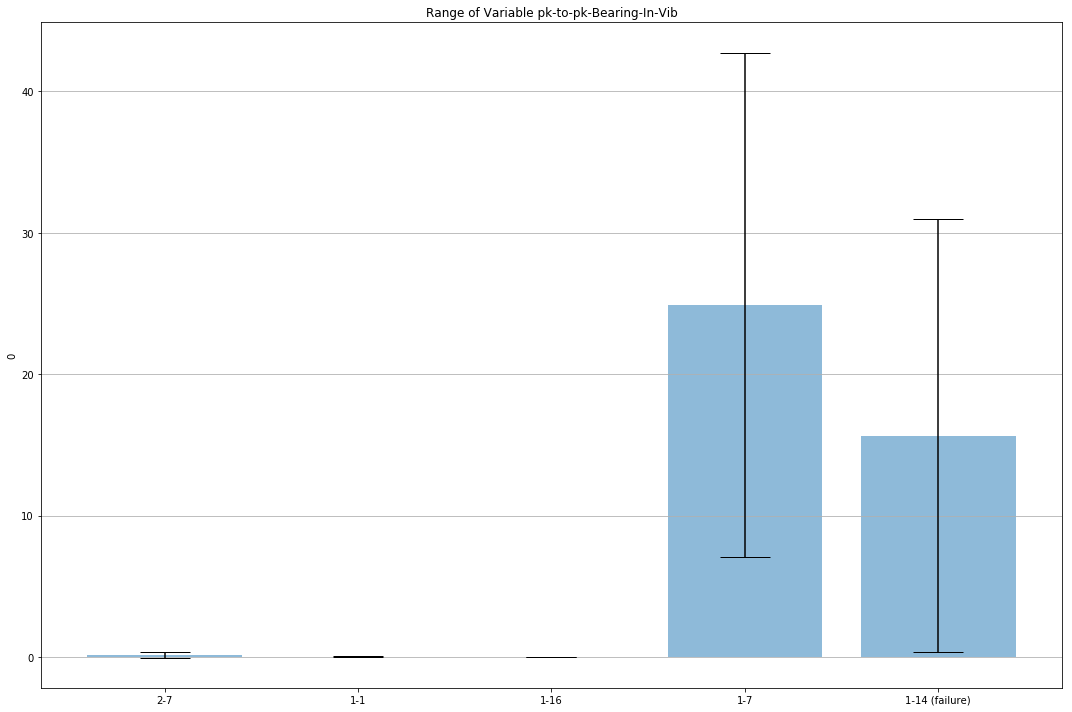

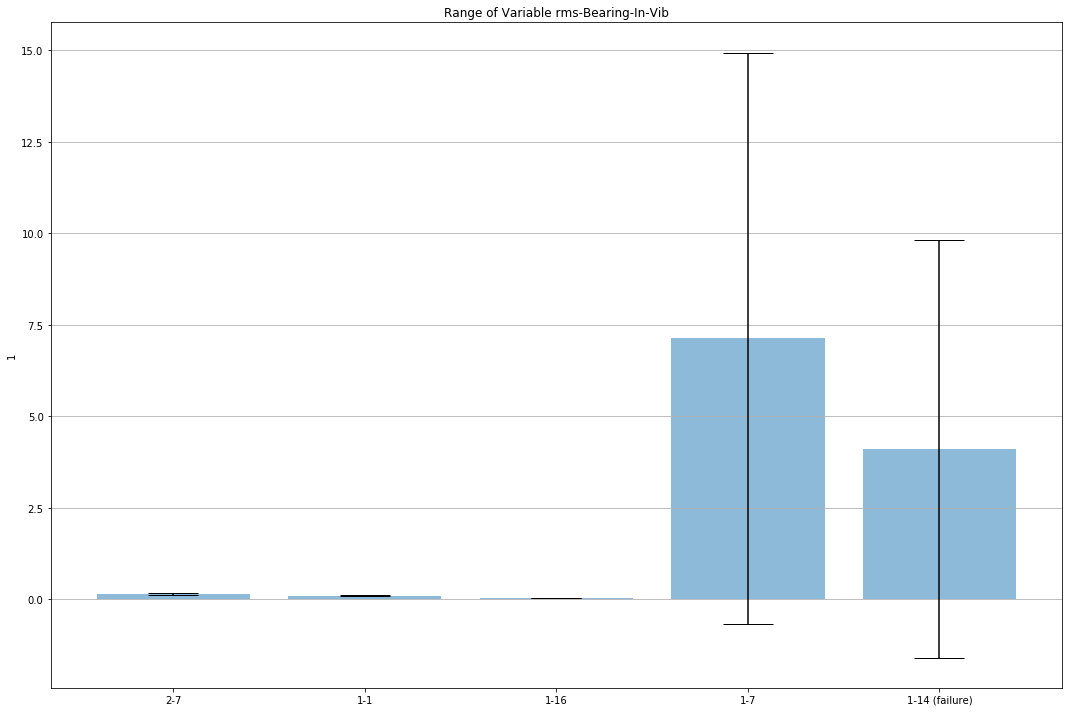

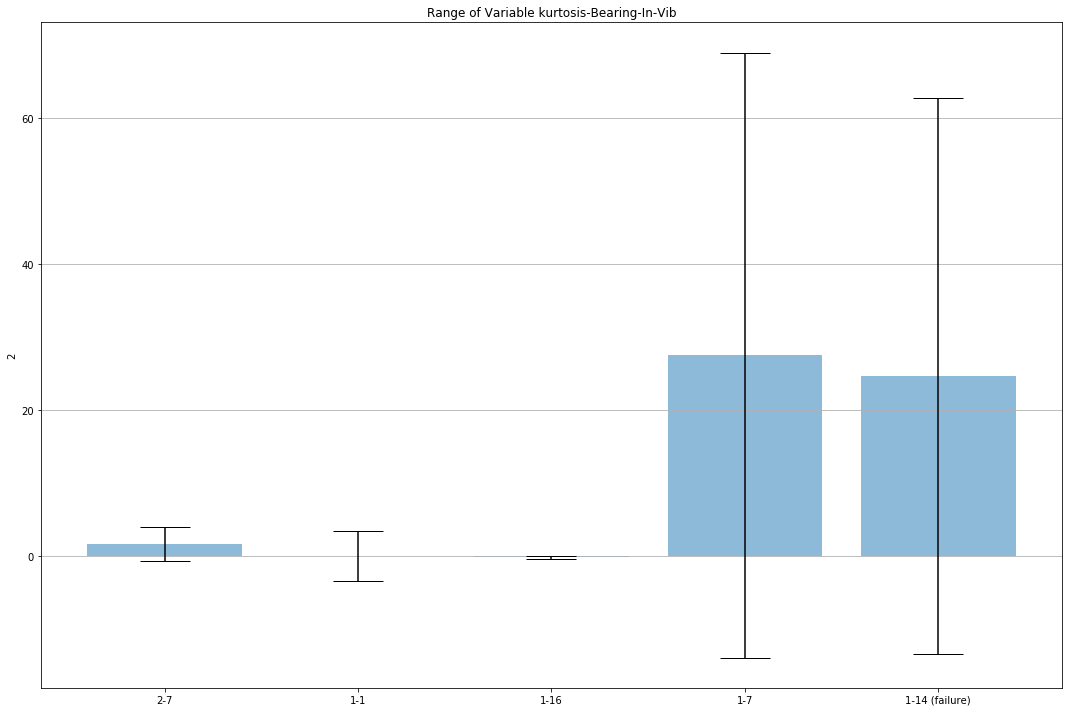

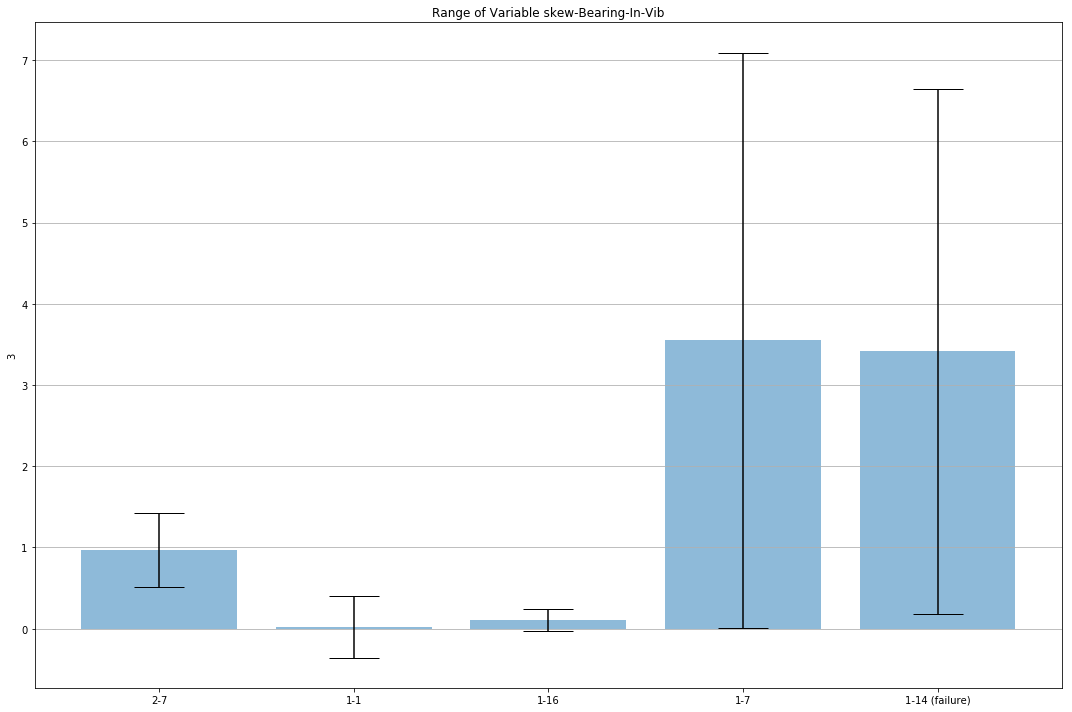

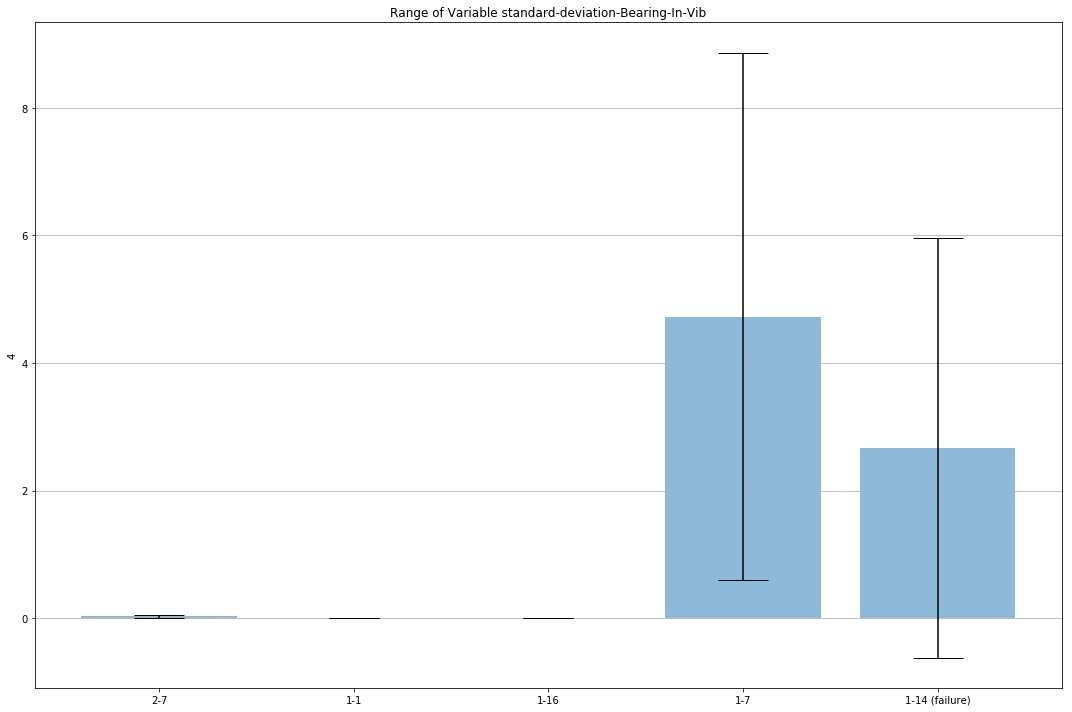

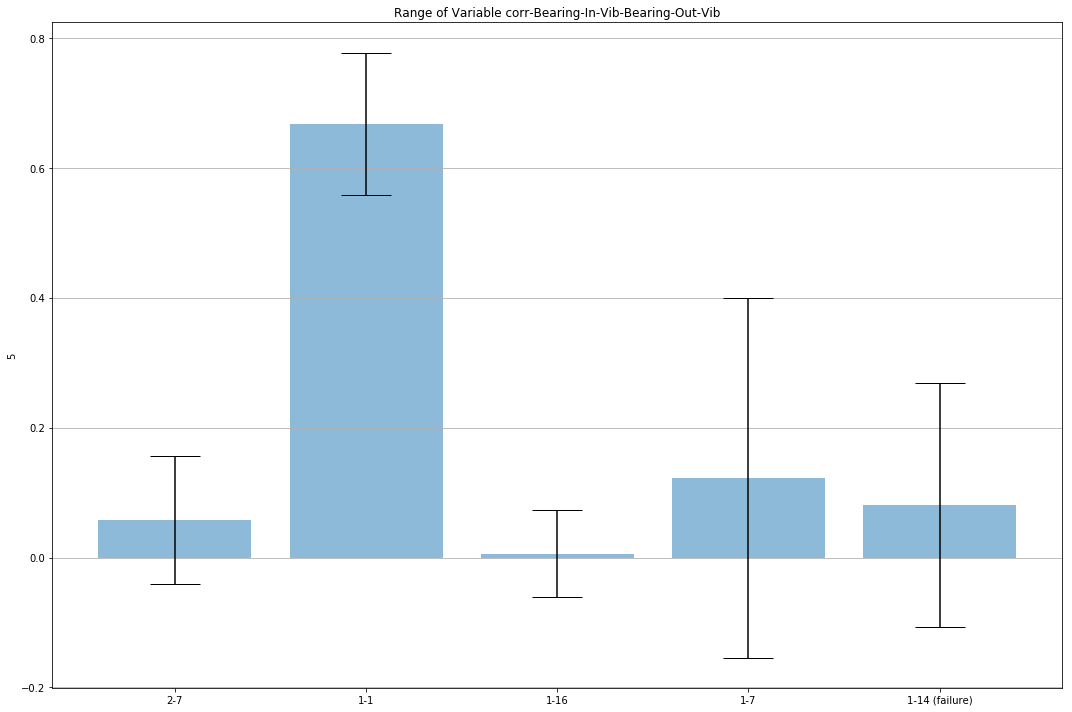

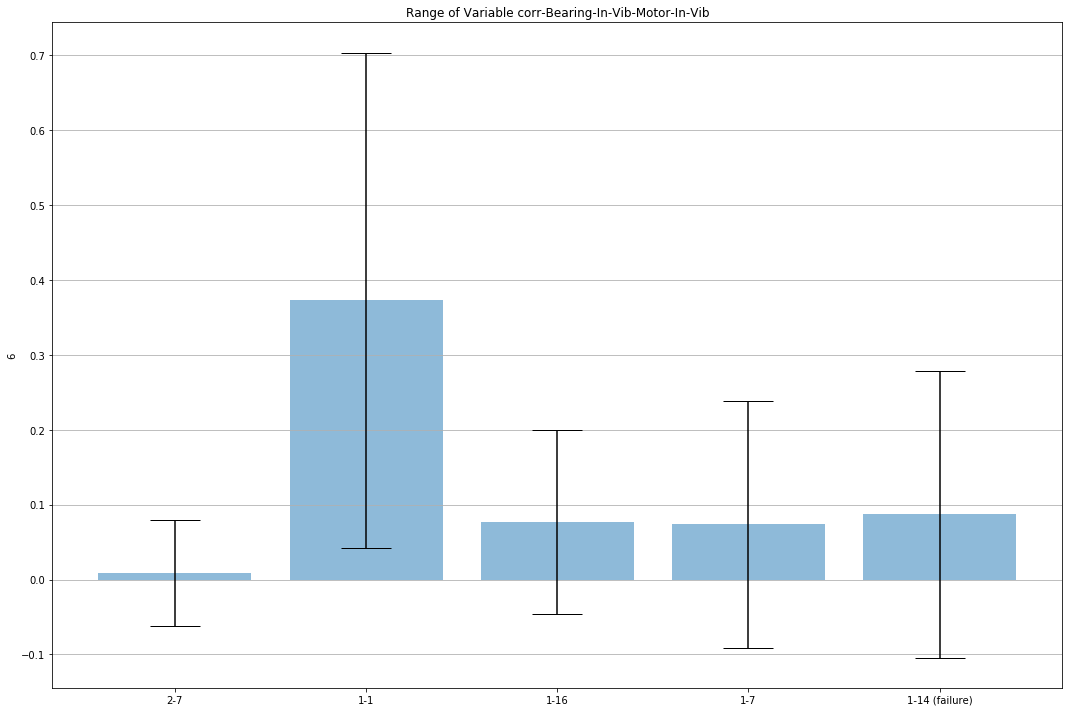

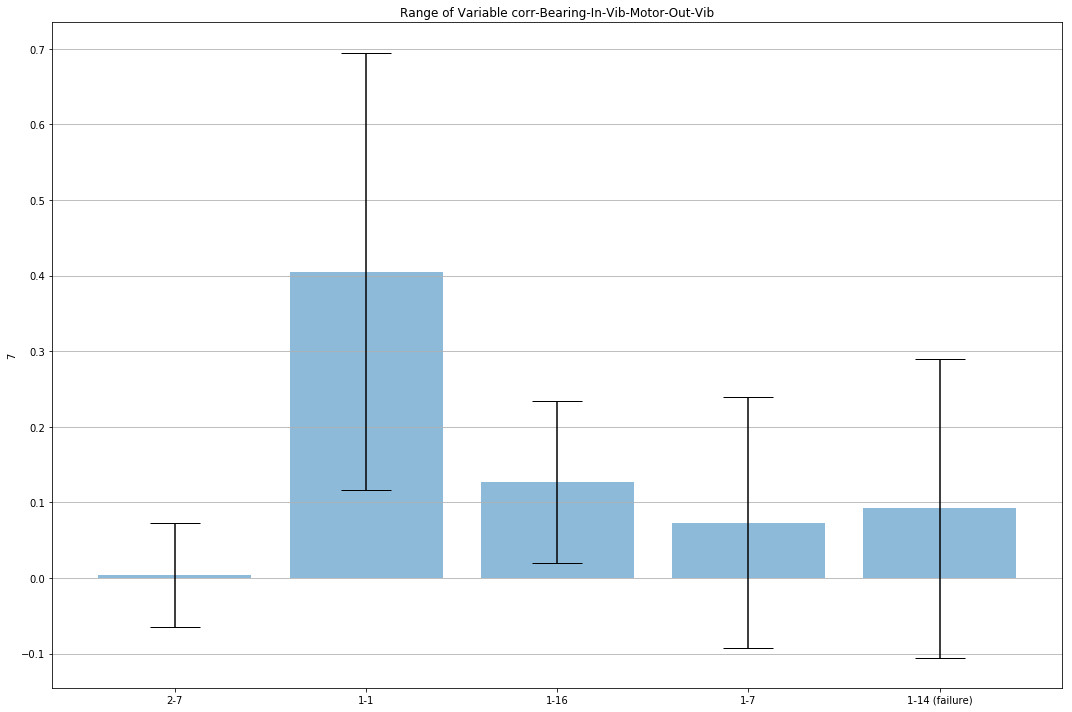

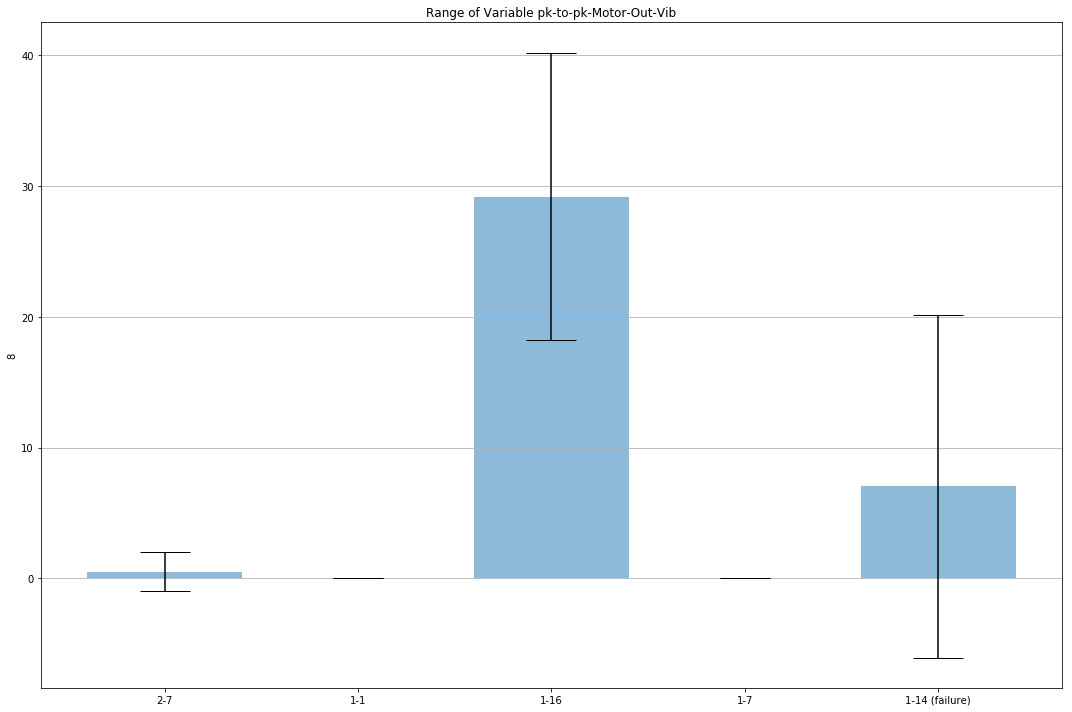

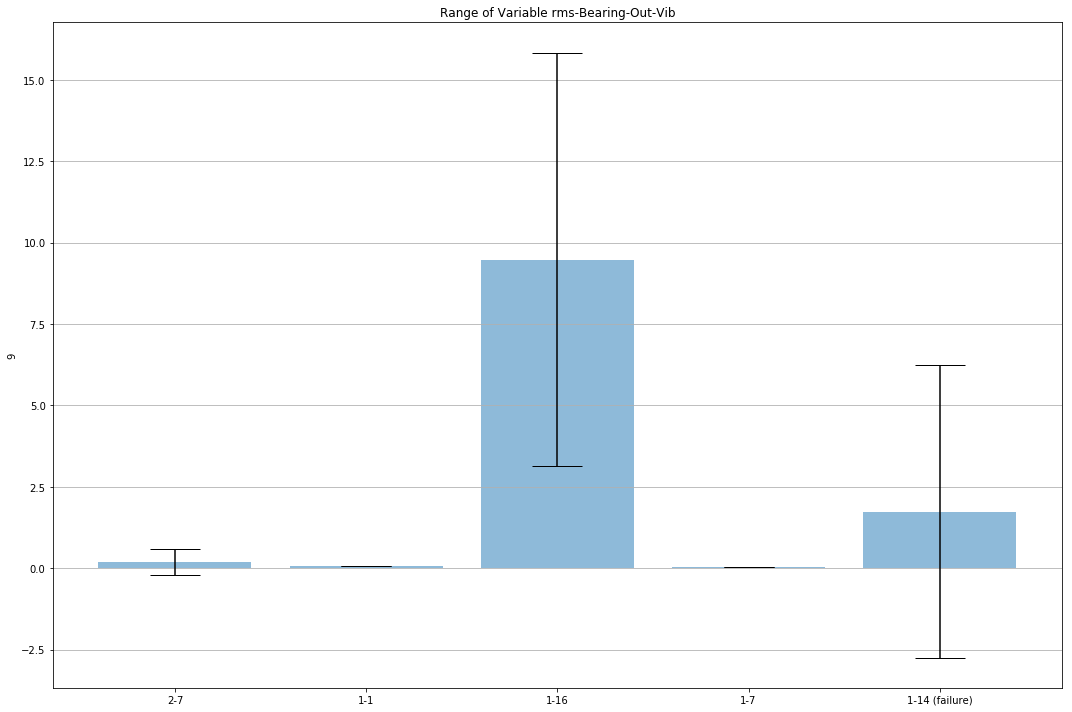

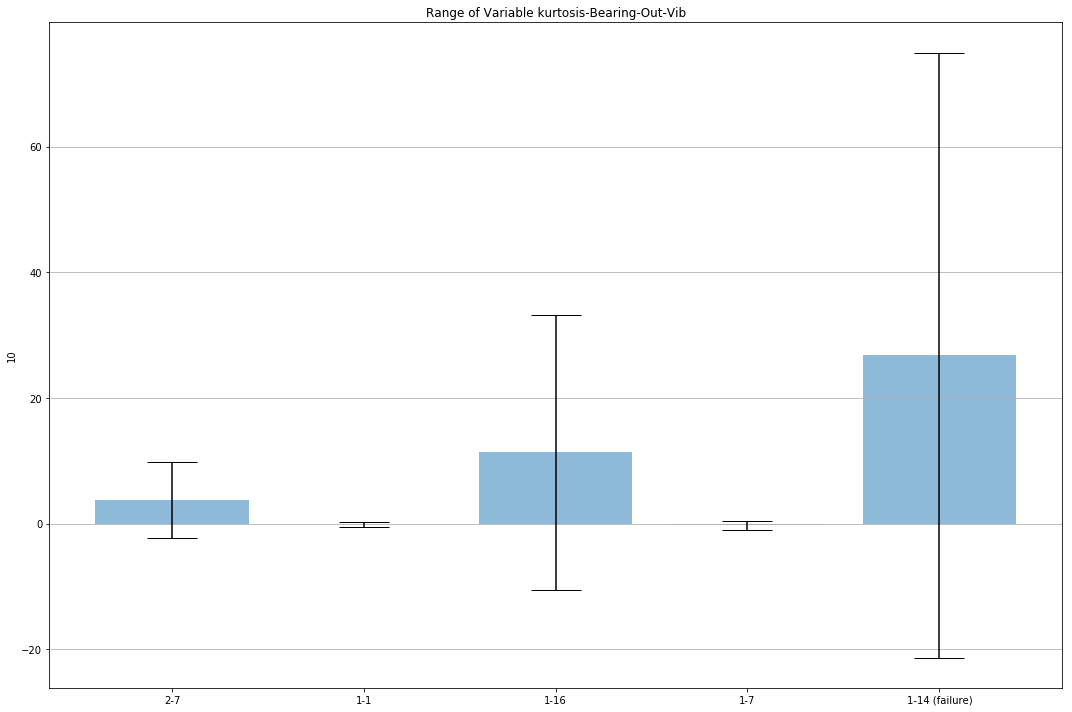

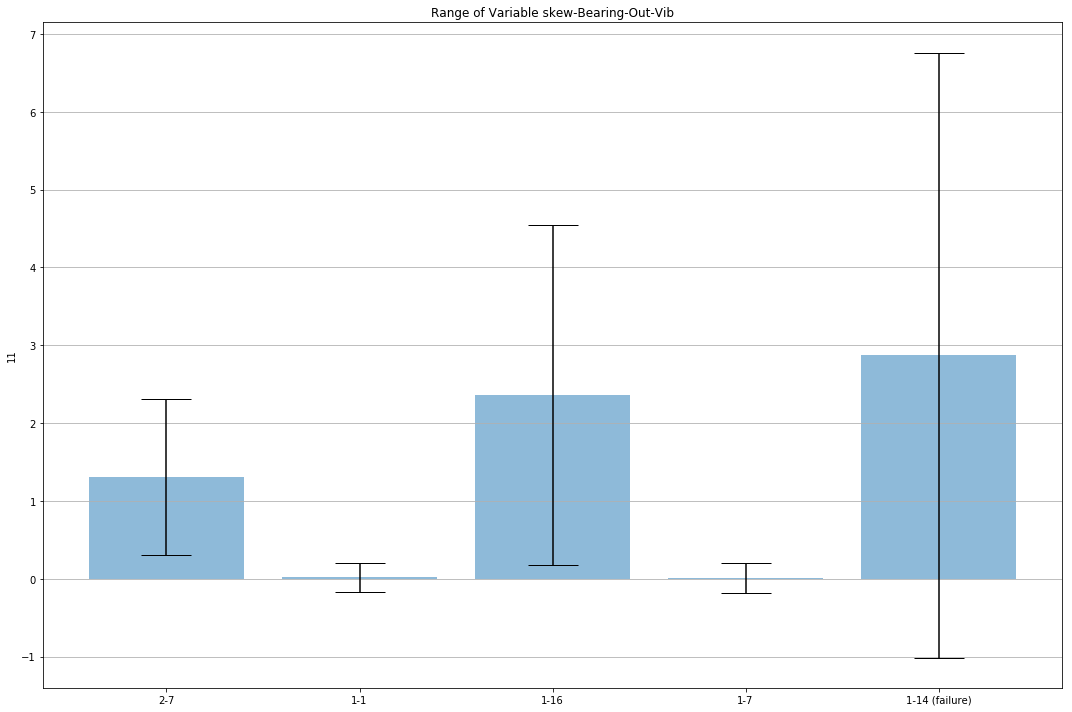

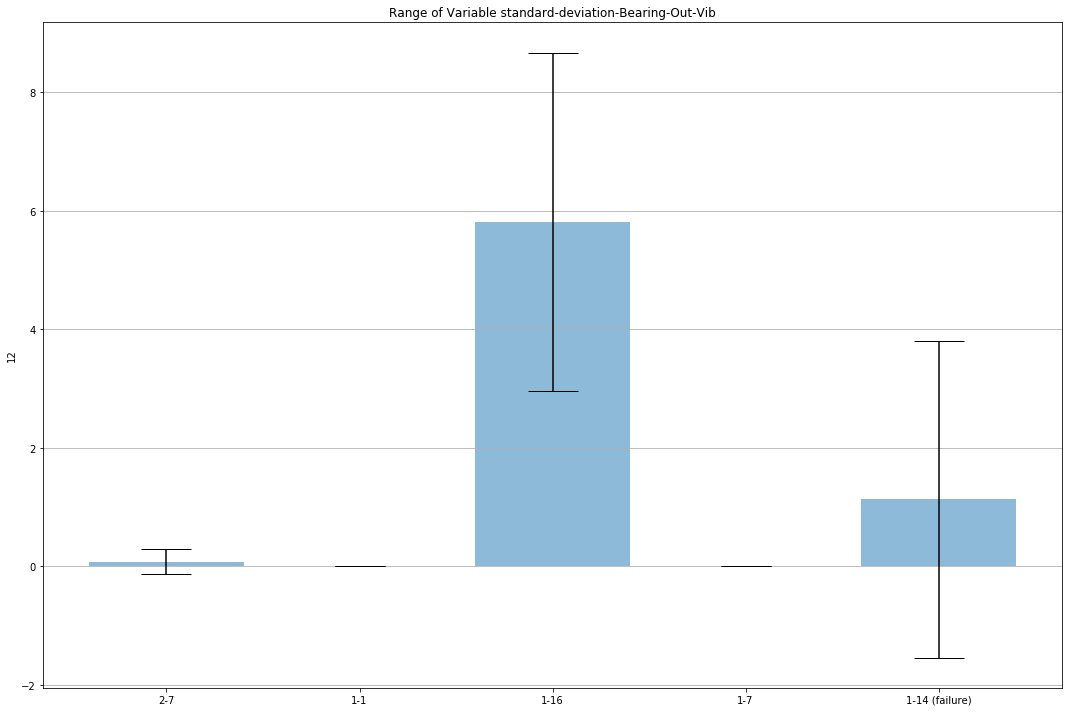

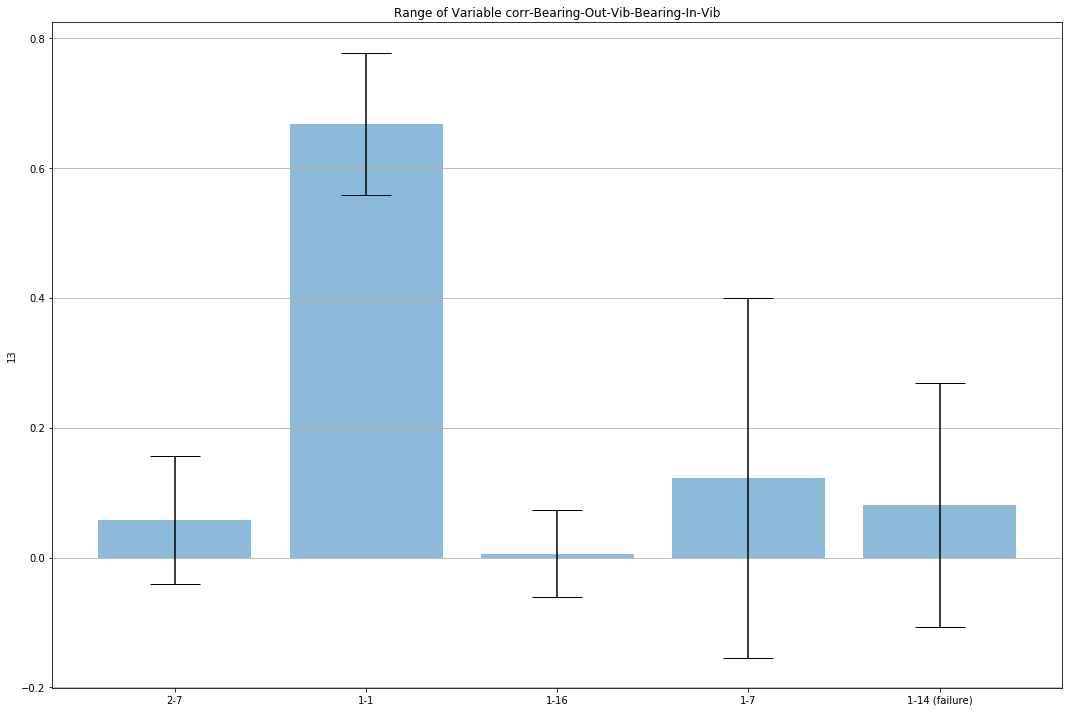

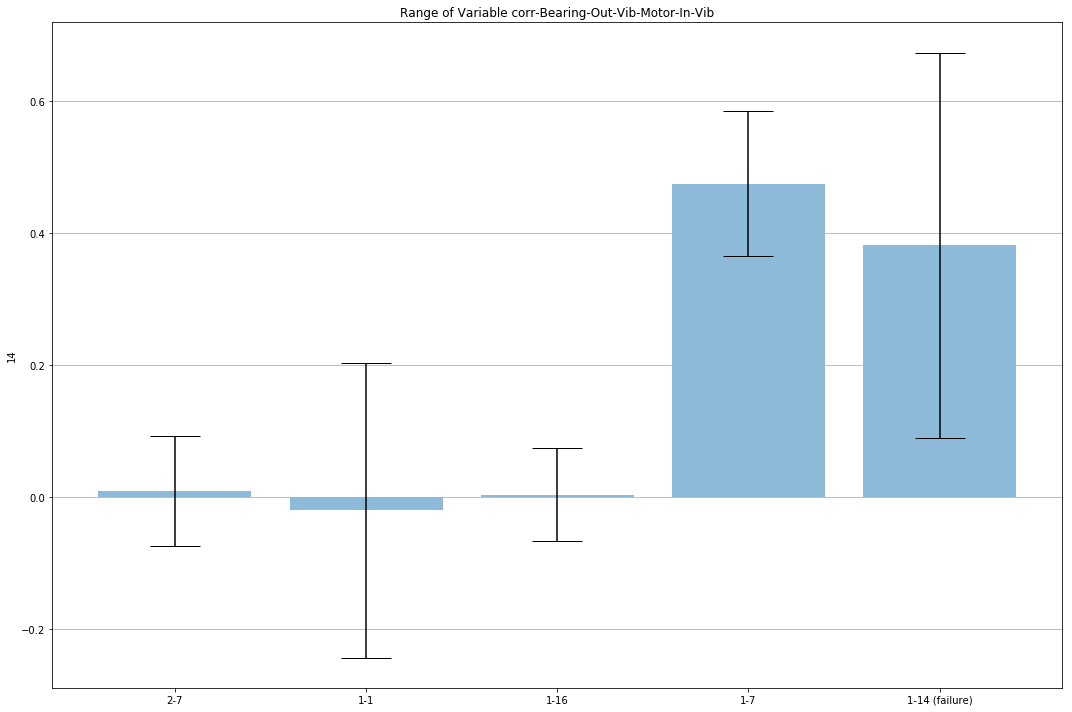

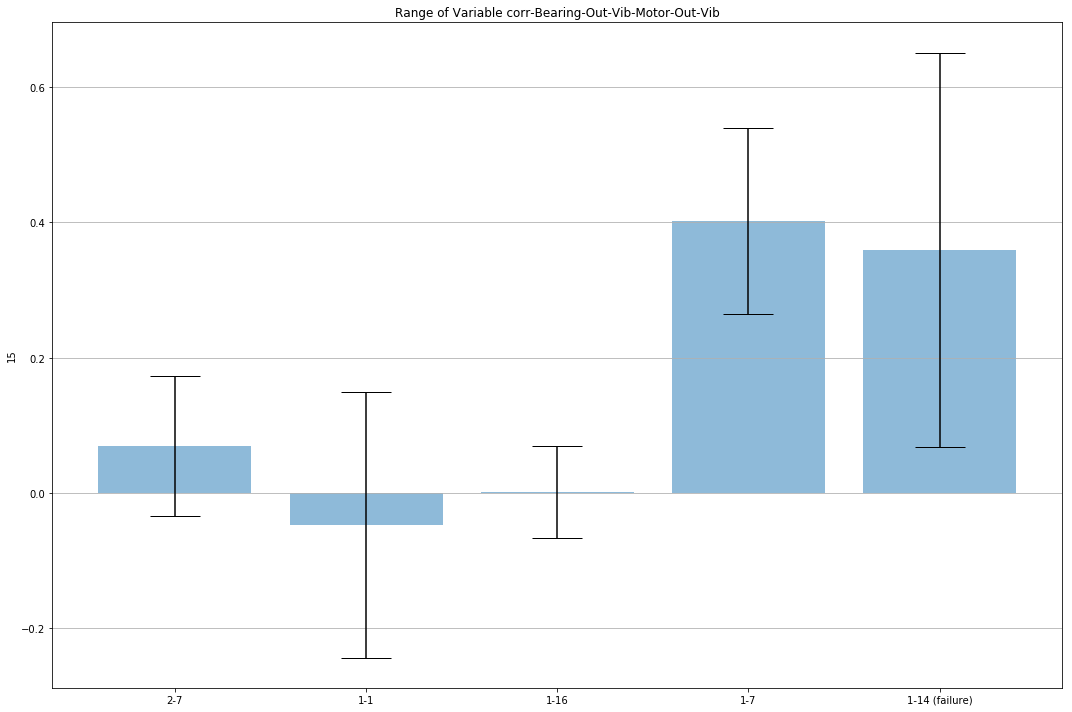

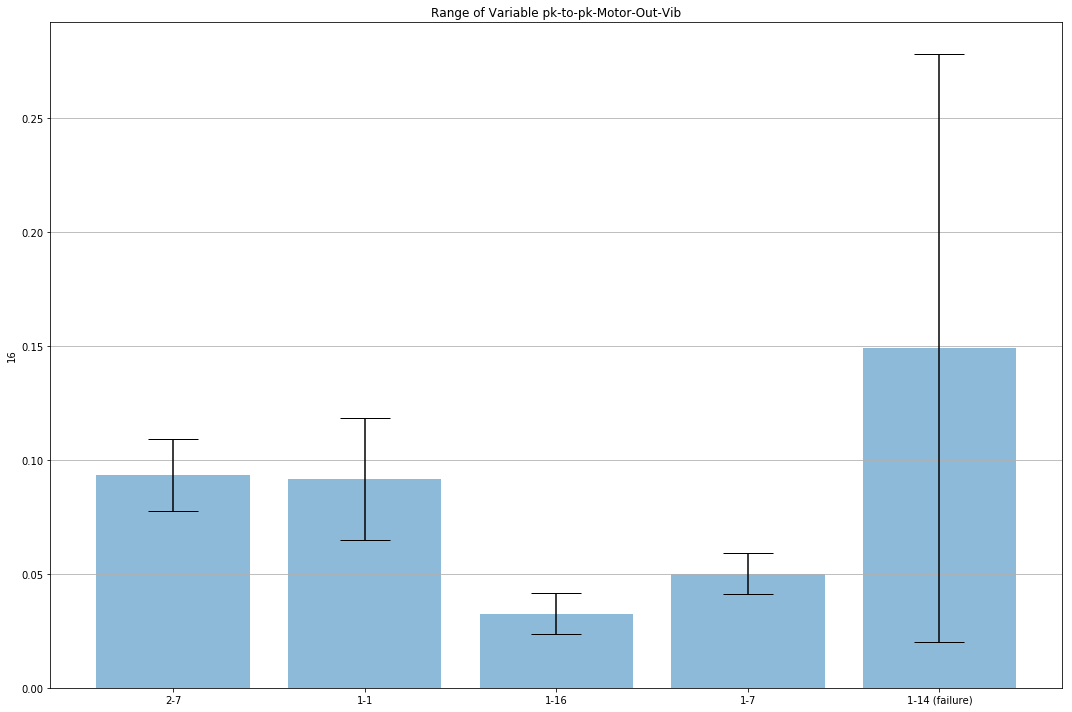

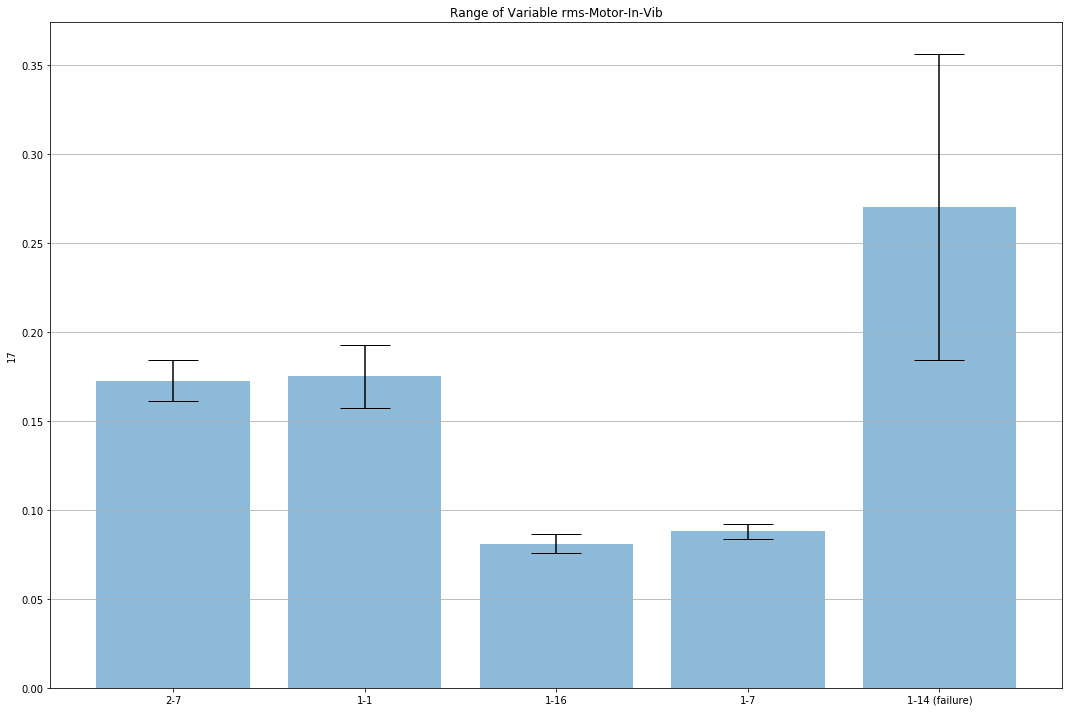

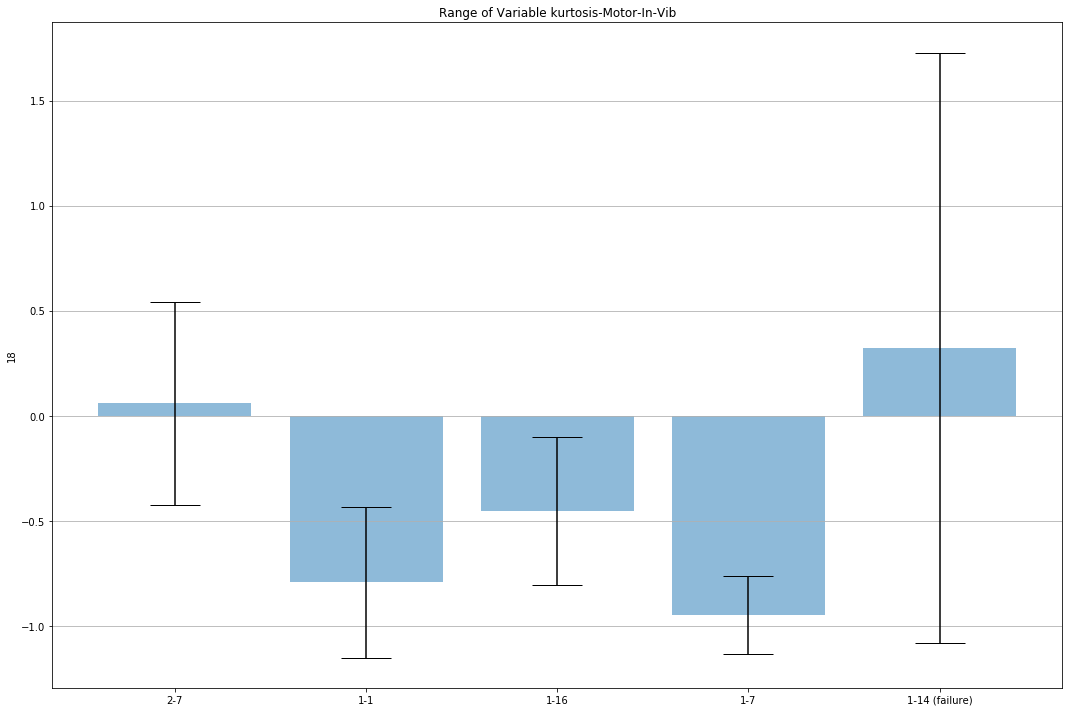

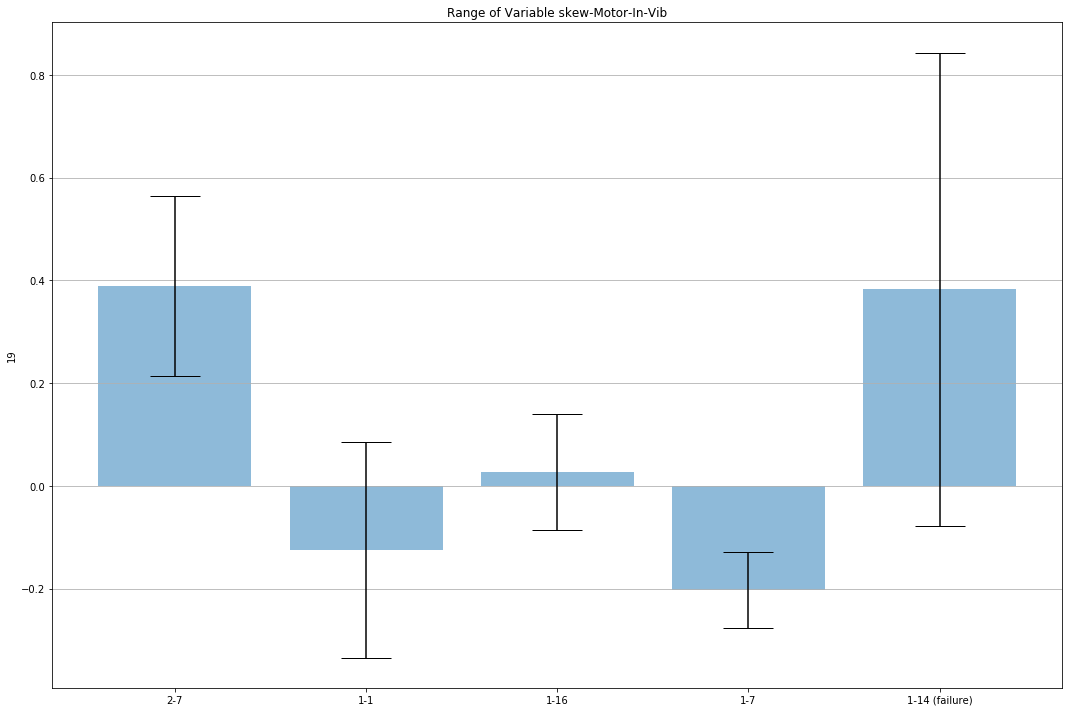

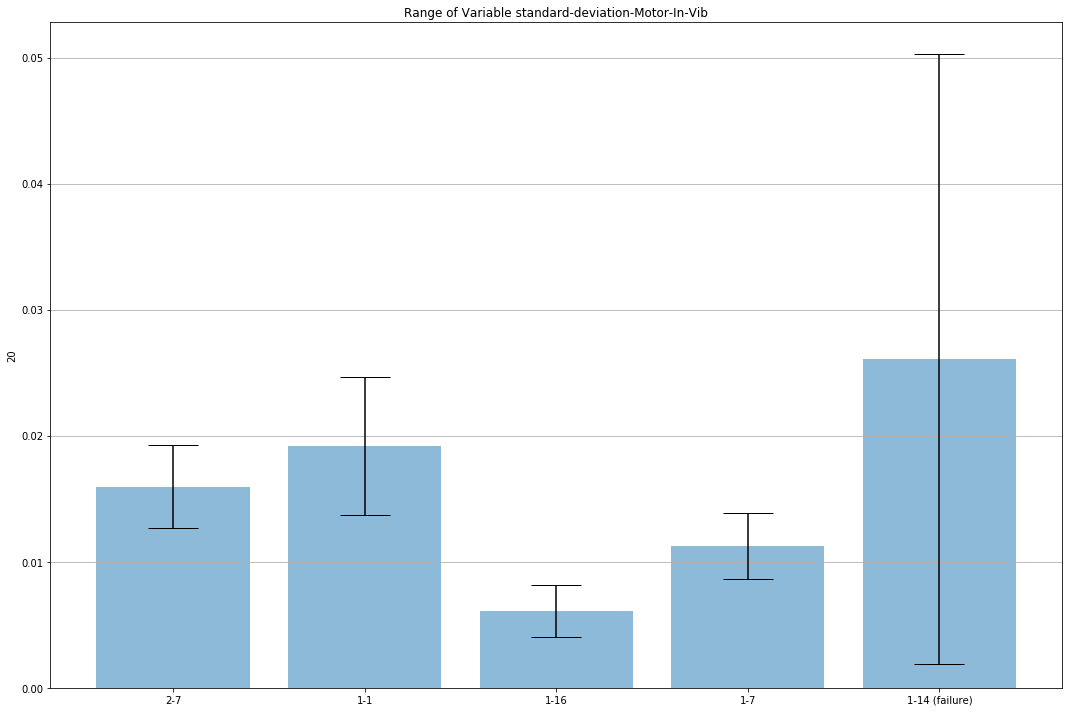

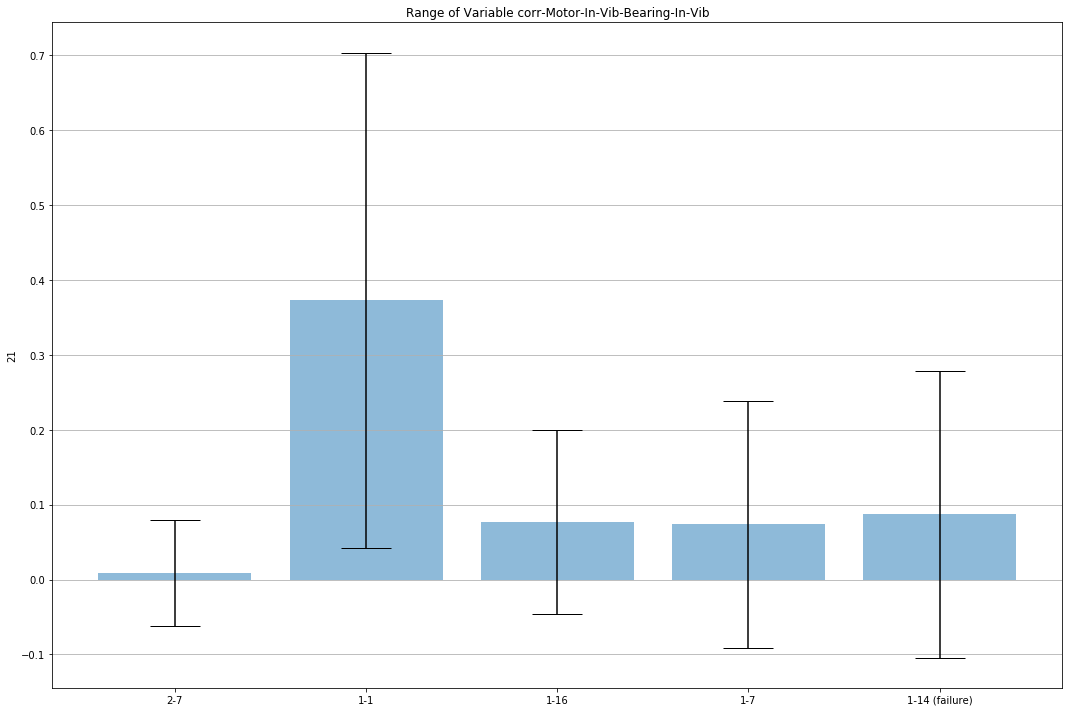

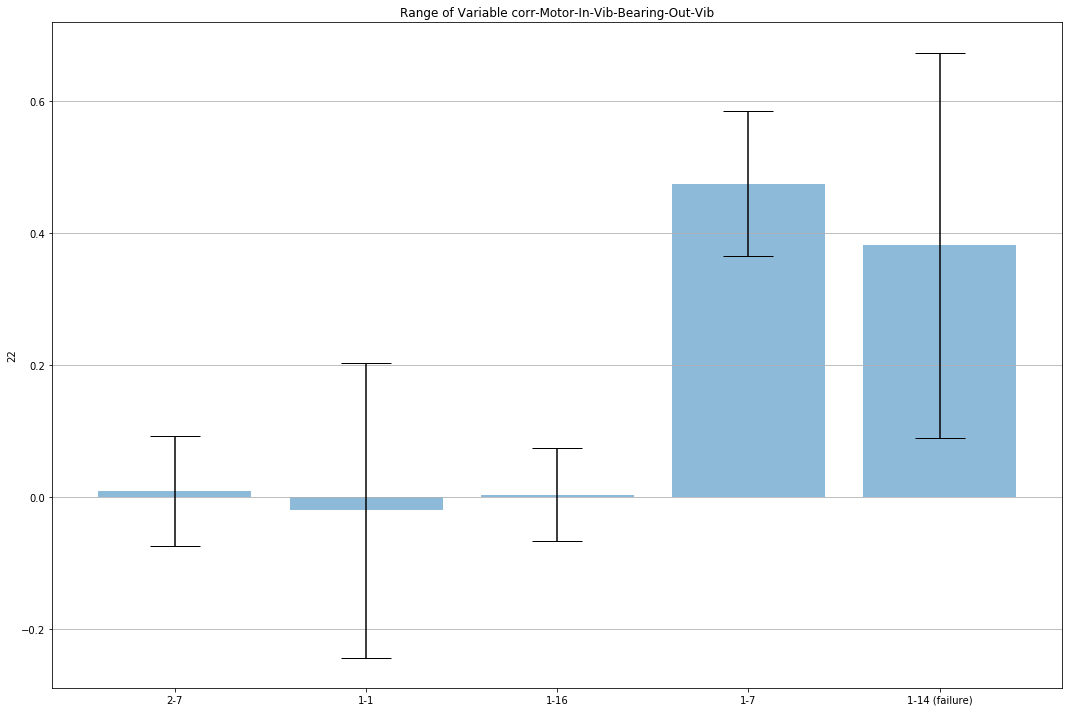

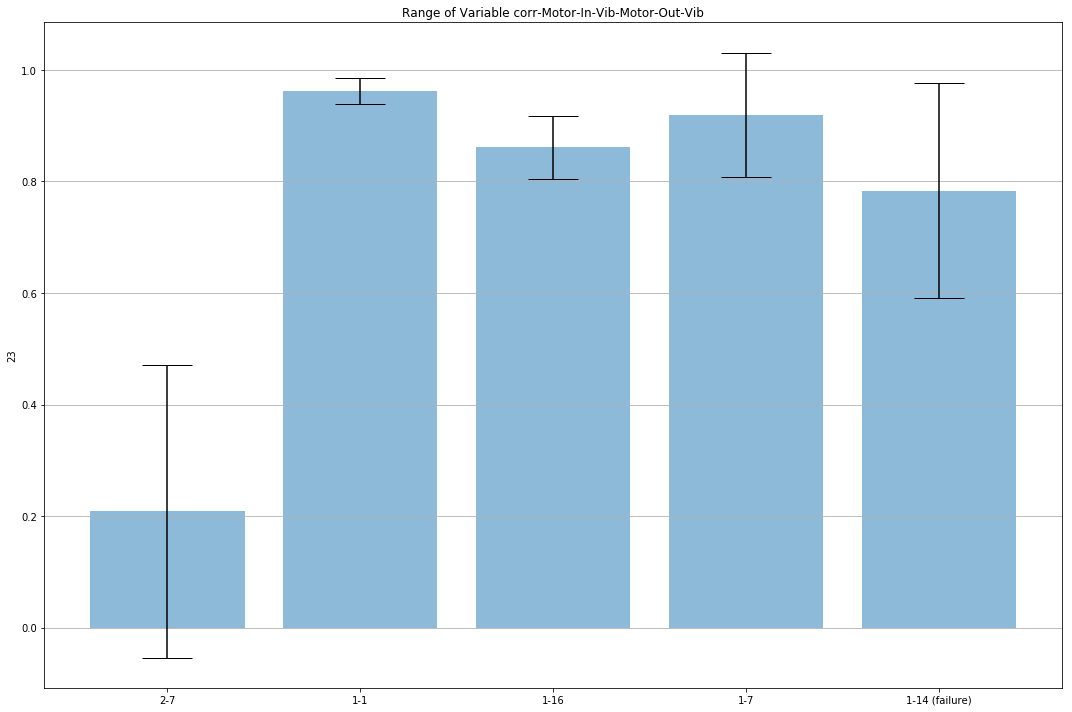

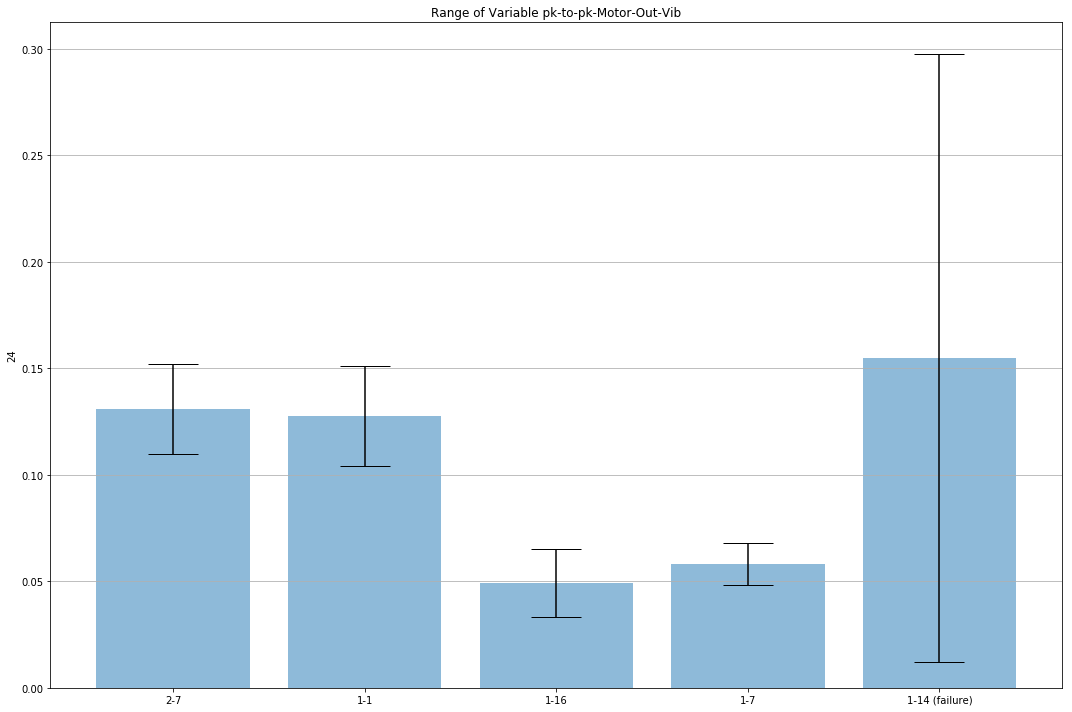

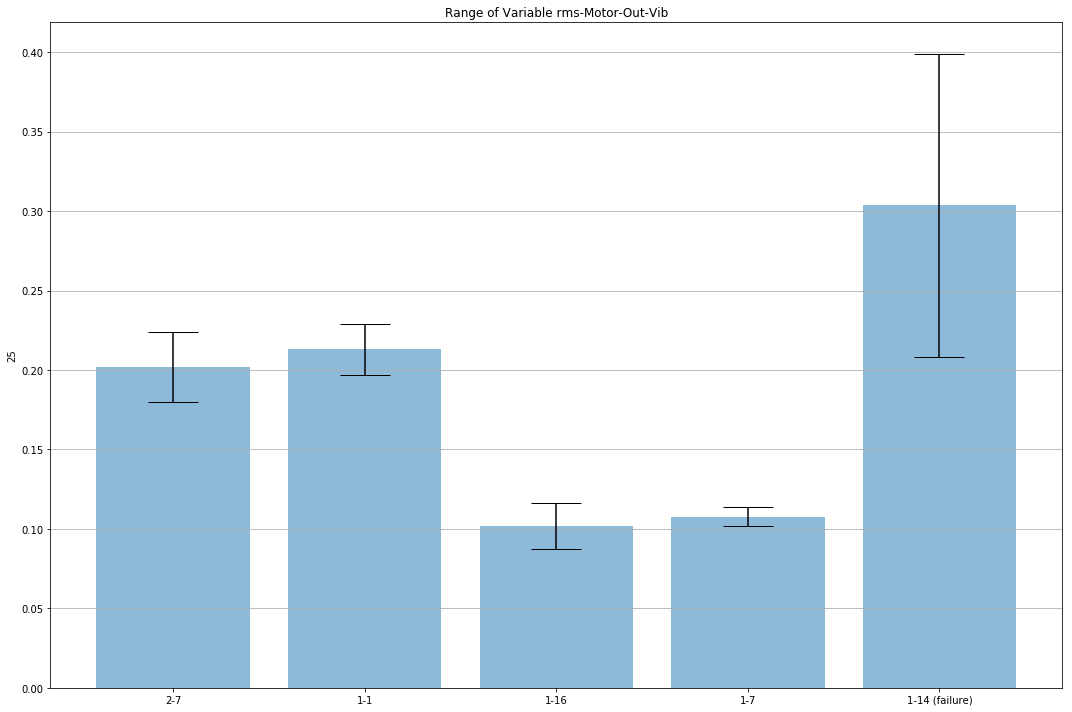

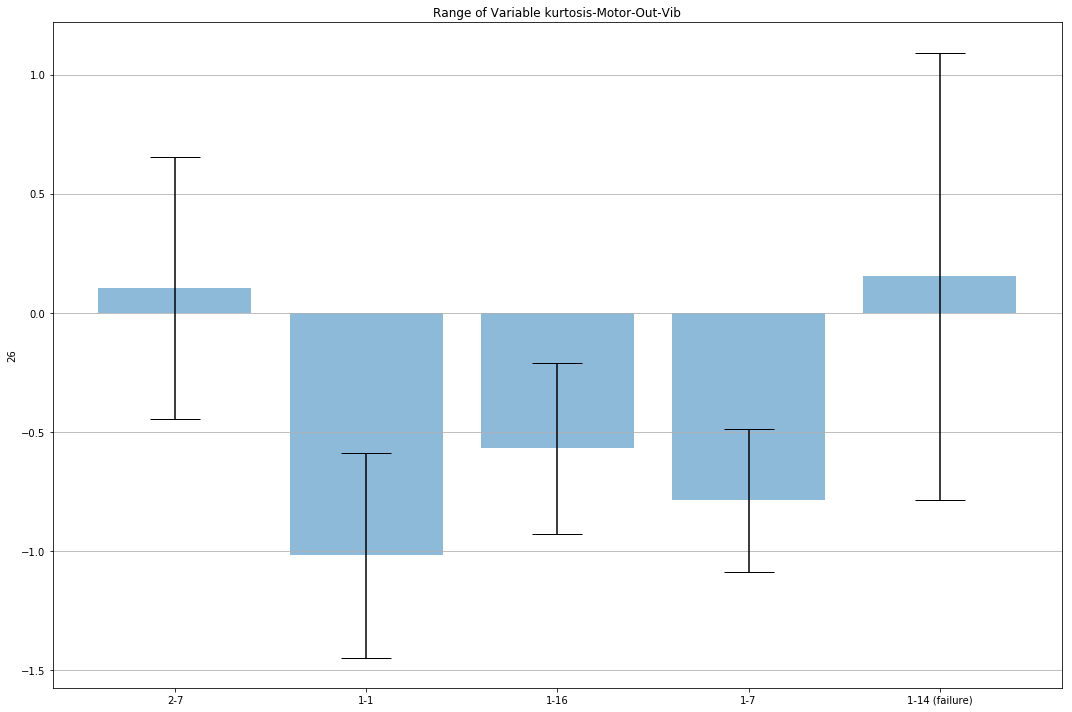

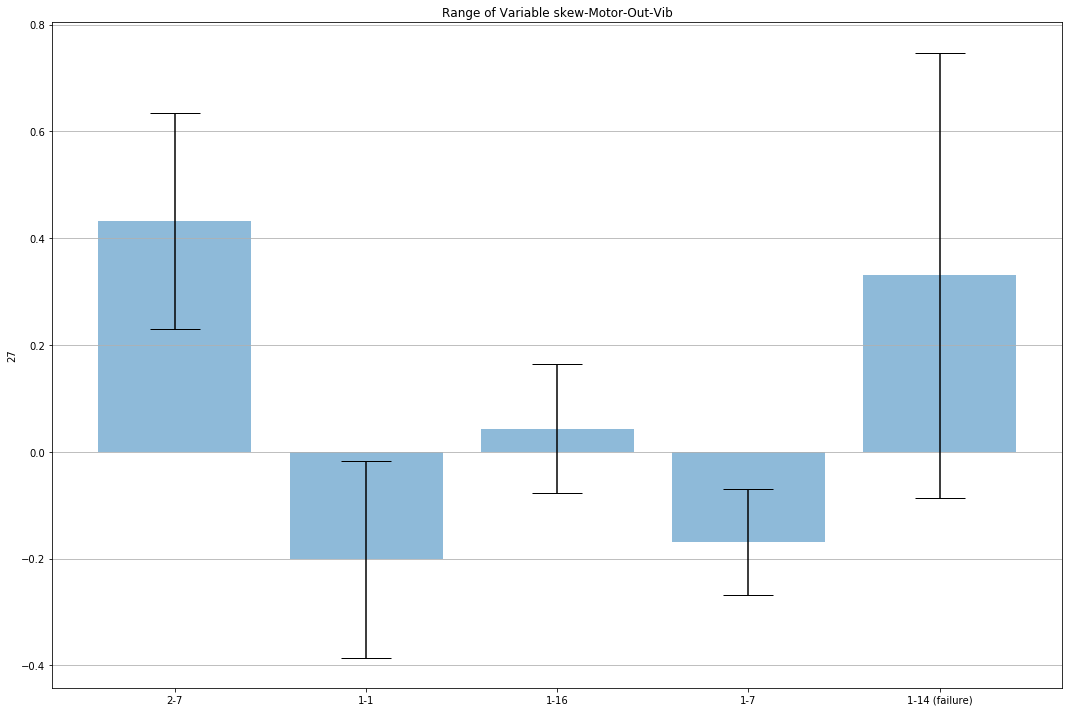

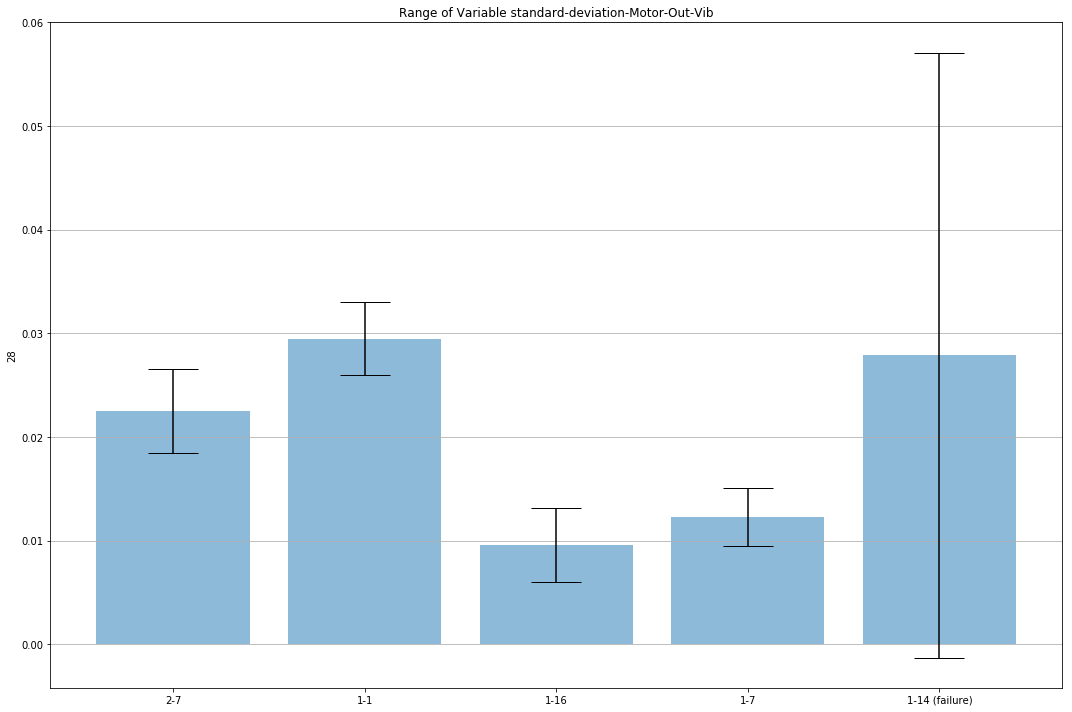

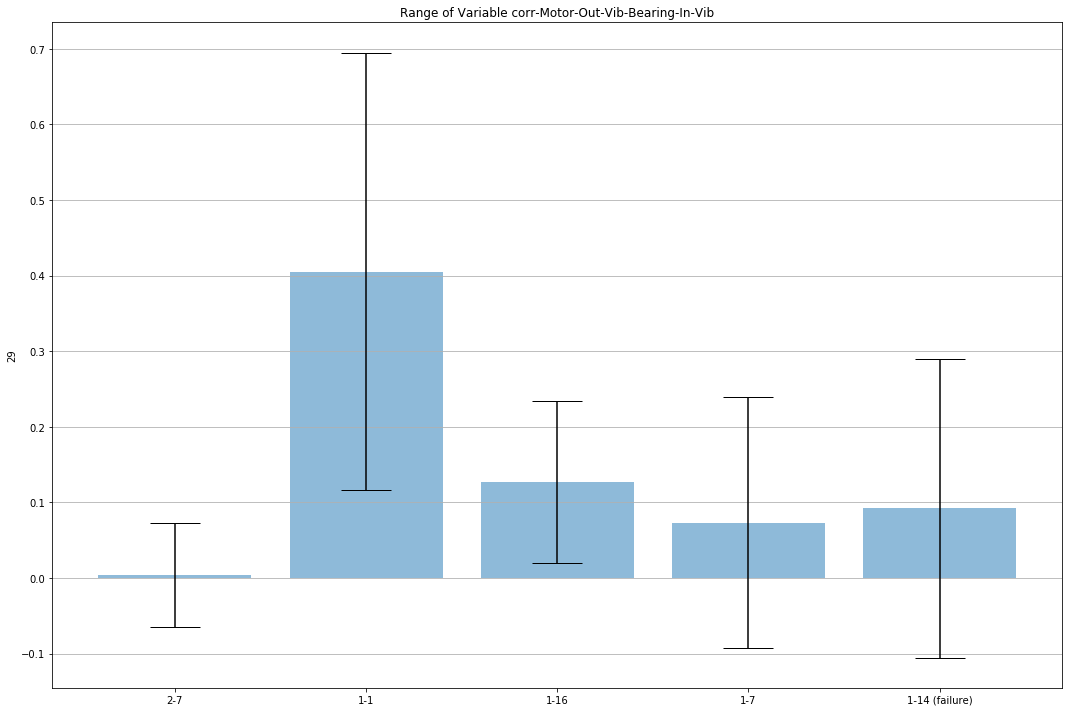

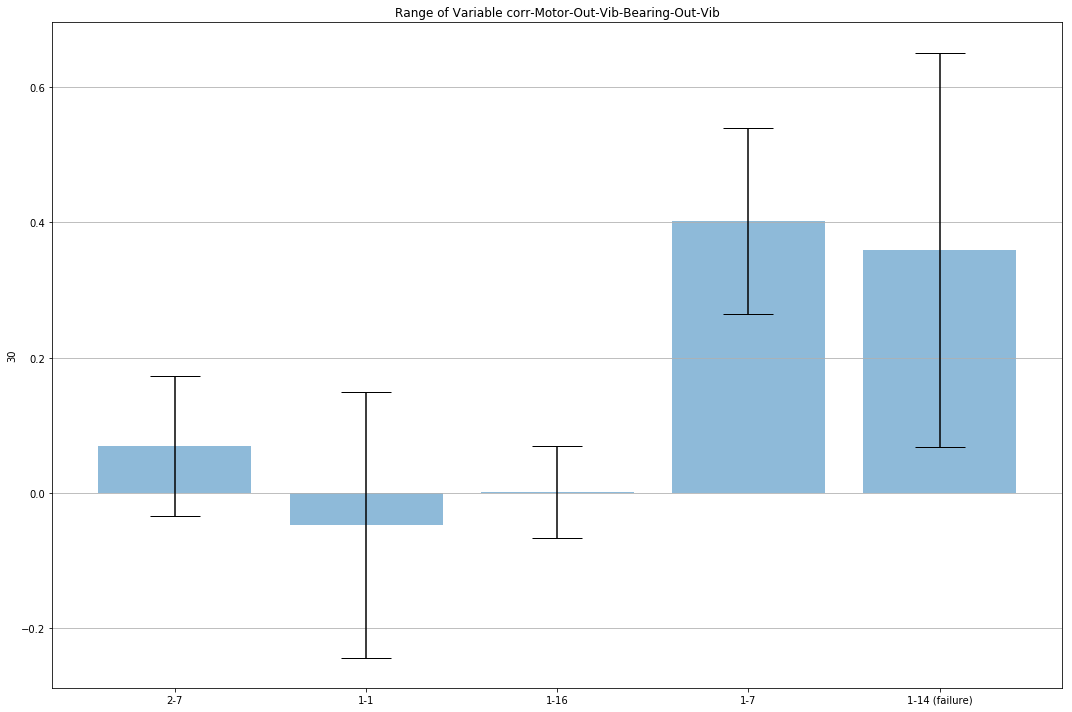

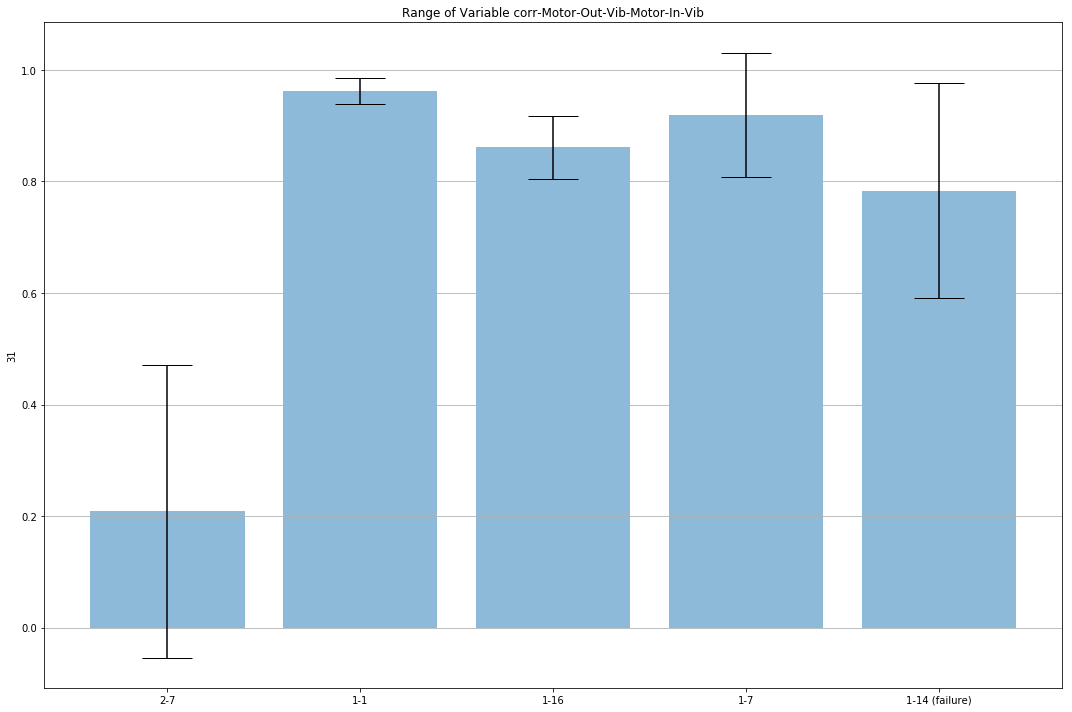

In [29]:

feb7, jan1, jan16, jan7, failure = get_training_data()
#ntrain, ndf1, ndf2, ndf3, ndf_failure = get_training_data_north()
gen_plots(feb7, jan1, jan16, jan7, failure)


In [32]:

label_feb7=create_label(feb7, 0)    
label_jan16=create_label(jan16, 0)    
label_failure=create_label(failure, 1)    

In [33]:
train = np.concatenate((feb7, jan16, failure))
labels = np.concatenate((label_feb7, label_jan16, label_failure))
train.shape
labels.shape

(2138,)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
train = pca.fit_transform(train)

In [35]:
clf = LogisticRegression(random_state=0, solver='lbfgs', n_jobs=-1)
clf.fit(train, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

feb 7th
0.9989189189189189


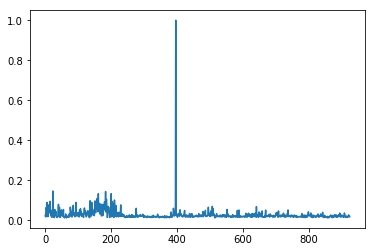

failure
0.9282407407407407


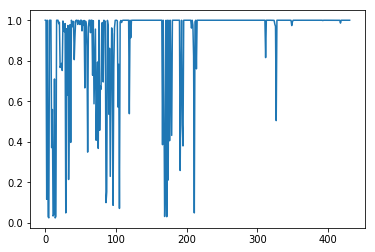

jan 16th
1.0


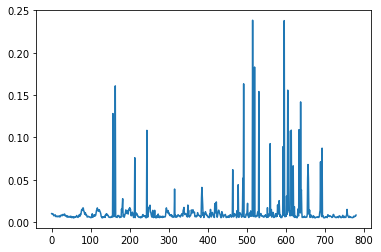

test jan 1st


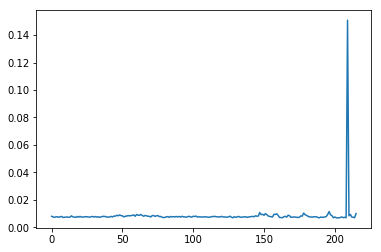

test jan 7th


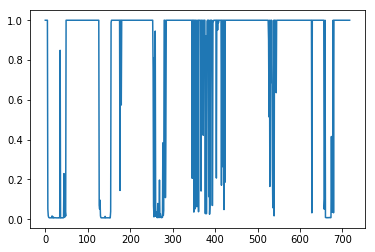

In [40]:
test = pca.transform(feb7)
pred = clf.predict_proba(test)
print("feb 7th")
print(clf.score(test, label_feb7))
plt.plot(pred[:,1])
plt.show()
pred
test = pca.transform(failure)
pred = clf.predict_proba(test)
print("failure")
print(clf.score(test, label_failure))
plt.plot(pred[:,1])
plt.show()

test = pca.transform(jan16)
pred = clf.predict_proba(test)
print("jan 16th")
print(clf.score(test, label_jan16))
plt.plot(pred[:,1])
plt.show()

test = pca.transform(jan1)
pred = clf.predict_proba(test)
print("test jan 1st")
plt.plot(pred[:,1])
plt.show()

test = pca.transform(jan7)
pred = clf.predict_proba(test)
print("test jan 7th")
plt.plot(pred[:,1])
plt.show()